In [1]:
import torch 
import torch.nn.functional as F
import numpy as np
from torch import nn

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# this is copy pasted from tutorial
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('../char-rnn-classify/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']
O'Neal


In [176]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_categories):
        super(Model,self).__init__()
        self.hidden_size = hidden_size
        
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        # self.i2h2 = nn.Linear(hidden_size, hidden_size)

        self.o2o = nn.Linear(output_size + hidden_size, output_size + hidden_size)
        self.o2o2 = nn.Linear(output_size + hidden_size, output_size)

        self.dropout = nn.Dropout(0.1)
        
    
    def forward(self, category, input, hidden):        
        combined = torch.cat((category, input, hidden), 1)
        # print('forward')
        # print('category', category)
        # print('input', input)
        # print('combined', combined)

        
        out = F.relu(self.i2o(combined))
        hidden = F.relu(self.i2h(combined))

        # out = self.i2o(combined)
        # hidden = self.i2h(combined)

        # hidden = F.relu(self.i2h2(hidden))
        
        combined = torch.cat((out, hidden), 1)

        # out = F.relu(self.o2o(combined))
        out = F.relu(self.o2o(combined))
        out = F.relu(self.o2o2(out))
        
        # out = self.dropout(out)
        # out = F.softmax(out, dim=1)

        return (out, hidden)
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)


In [5]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

def lineToTensorTarget(line):
    tensor = torch.zeros(len(line)+1, 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    
    tensor[len(line)][0][n_letters-1] = 1
    return tensor


# Prepare the dataset

1. For each word hot encode it, add 1 special EOS char in the end.
2. Split each word into first n-1 and last n-1 chars.
3. Each batch will be just one word. Feed consecutively each letter and accumulate loss over the word and then call backwards.

In [6]:
def getCategoryIndex(category, all_categories):
    return all_categories.index(category)

def encodeCategory(category, all_categories, all_categories_size):
    index = getCategoryIndex(category, all_categories)
    tensor = torch.zeros(1, all_categories_size)
    tensor[0,index] = 1.0

    return tensor

getCategoryIndex('English',all_categories)

encodeCategory('English',all_categories, len(all_categories))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [7]:
# labels all_categories 
# dict category_lines

# LongTensor of second letter to end (EOS) for target
# this is for log loss function
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)


# each tuple in dataset = (direction vec + encoded letter)
dataset = []

all_categories_size = len(all_categories)

for category in all_categories:
    category_encoded = encodeCategory(category, all_categories, all_categories_size)
    for word_index in range(0, min(500,len(category_lines[category]))):
        word = category_lines[category][word_index]
        print('word', word, 'category', category)
        word_begin_tensor = lineToTensor(word)
        word_end_tensor = lineToTensorTarget(word[1:])
        

        dataset.append((category_encoded, word_begin_tensor, word_end_tensor))


word Abl category Czech
word Adsit category Czech
word Ajdrna category Czech
word Alt category Czech
word Antonowitsch category Czech
word Antonowitz category Czech
word Bacon category Czech
word Ballalatak category Czech
word Ballaltick category Czech
word Bartonova category Czech
word Bastl category Czech
word Baroch category Czech
word Benesch category Czech
word Betlach category Czech
word Biganska category Czech
word Bilek category Czech
word Blahut category Czech
word Blazek category Czech
word Blazek category Czech
word Blazejovsky category Czech
word Blecha category Czech
word Bleskan category Czech
word Blober category Czech
word Bock category Czech
word Bohac category Czech
word Bohunovsky category Czech
word Bolcar category Czech
word Borovka category Czech
word Borovski category Czech
word Borowski category Czech
word Borovsky category Czech
word Brabbery category Czech
word Brezovjak category Czech
word Brousil category Czech
word Bruckner category Czech
word Buchta catego

In [104]:
import random
random.shuffle(dataset)
len(dataset)

5555

In [105]:
# for cat in all_categories:
#     print(cat, len(category_lines[cat]))


for i in range(100):
    print(all_categories[dataset[i][0].argmax()])

Russian
Spanish
Russian
Japanese
Dutch
Chinese
Dutch
Russian
French
Russian
Italian
Russian
Czech
English
German
Dutch
Czech
English
Japanese
English
German
English
French
German
Japanese
German
French
Russian
English
Czech
Italian
Dutch
Polish
Japanese
Japanese
Japanese
Italian
English
Japanese
Dutch
Dutch
Italian
Greek
Dutch
Japanese
Russian
Czech
Japanese
Russian
German
Arabic
Irish
Korean
Japanese
French
Italian
Irish
Czech
German
Russian
German
Vietnamese
English
Polish
Italian
English
Arabic
Spanish
Polish
Chinese
Greek
Italian
Japanese
Czech
French
Czech
Italian
Japanese
German
Arabic
Japanese
Japanese
Czech
Irish
Russian
Czech
Japanese
Irish
Chinese
English
English
Russian
Dutch
Czech
Italian
German
French
Russian
English
Scottish


In [177]:
model = Model(n_letters, 128, n_letters, len(all_categories))
criterion = nn.CrossEntropyLoss()

In [185]:
n_epochs = 5
learning_rate = 0.003

all_losses = []
plot_every = 200
total_loss = 0.0
batch = 16

for epoch in range(n_epochs):
    index = 0
    batch = 0
    for data in dataset:
        index += 1
        batch += 1
        direction, letter_input, letter_target = data
        
        target = letter_target #.unsqueeze(-1)
        model.zero_grad()
        loss = 0
        
        hidden = model.init_hidden()
        for letter_index in range(letter_input.size(0)):
            output, hidden = model(direction, letter_input[letter_index], hidden)
            # print(output, target[letter_index])
            loss += criterion(output, target[letter_index])
        
        normalized_loss = loss.item() / (letter_input.size(0) + 0.0)
        total_loss += normalized_loss

        if index % batch == 0:
            loss.backward()
        
        for p in model.parameters():
            p.data.add_(p.grad.data, alpha=-learning_rate)
        
        if index % plot_every == 0:
            all_losses.append(total_loss / (plot_every + 0.0))
            total_loss = 0
            print('index.. ', index, 'epoch...... ', epoch, ' loss...... ',all_losses[-1])


index..  200 epoch......  0  loss......  2.05151606176357
index..  400 epoch......  0  loss......  2.0488007176066754
index..  600 epoch......  0  loss......  2.0290647395881054
index..  800 epoch......  0  loss......  2.0323141999687904
index..  1000 epoch......  0  loss......  2.0341372281768786
index..  1200 epoch......  0  loss......  1.9563775743352725
index..  1400 epoch......  0  loss......  1.9964895509222549
index..  1600 epoch......  0  loss......  1.9916143272136357
index..  1800 epoch......  0  loss......  1.9785721255871125
index..  2000 epoch......  0  loss......  2.0217605749543996
index..  2200 epoch......  0  loss......  1.940132830179549
index..  2400 epoch......  0  loss......  1.98921158732876
index..  2600 epoch......  0  loss......  2.058992261972023
index..  2800 epoch......  0  loss......  1.995393963679831
index..  3000 epoch......  0  loss......  1.90712775458376
index..  3200 epoch......  0  loss......  1.978061124997943
index..  3400 epoch......  0  loss....

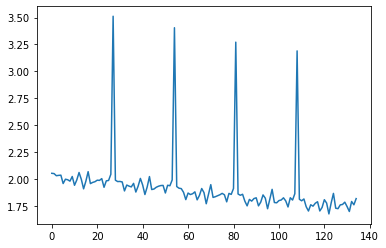

In [186]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [11]:
direction, letter_input, letter_target = dataset[5]
letter_target.unsqueeze(-1)

model.zero_grad()
loss = torch.tensor(0.0)
hidden = model.init_hidden()
output, hidden = model(direction, letter_input[letter_index], hidden)

output[0], letter_target[0]

IndexError: index 4 is out of bounds for dimension 0 with size 3

In [134]:
# Just return an output given a line
def evaluate(direction, first_letter):
    with torch.no_grad():
        direction_tensor = encodeCategory(direction, all_categories, all_categories_size)
        letter_tensor = letterToTensor(first_letter)
        hidden = model.init_hidden()

        limit = 10

        outputs = first_letter

        for i in range(limit):
            output, hidden = model(direction_tensor, letter_tensor, hidden)
            position = torch.argmax(output)
            if position == len(all_letters):
                break
            outputs += all_letters[position]

            letter_tensor = torch.zeros(1, n_letters)
            letter_tensor[0][position] = 1

        return outputs

In [194]:
letter = 'F'
print(evaluate('Russian', letter))
print(evaluate('Japanese', letter))
print(evaluate('Spanish', letter))
print(evaluate('Chinese',letter))
print(evaluate('German', letter))


letter = 'S'
print(evaluate('Russian', letter))
print(evaluate('Japanese', letter))
print(evaluate('Spanish', letter))
print(evaluate('Chinese',letter))
print(evaluate('German', letter))

letter = 'Q'
print(evaluate('Russian', letter))
print(evaluate('Japanese', letter))
print(evaluate('Spanish', letter))
print(evaluate('Chinese',letter))
print(evaluate('German', letter))

Fallarov
Fukusa
Ferrerria
Fing
Ferter
Salkin
Saika
Sarra
Shang
Seifer
Quroff
Qukusa
Qurrez
Quan
Qurter
